In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from stroke_risk_utils import *
from IPython.display import Image

In [4]:
stroke_df = pd.read_csv("stroke_dataset.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
print(stroke_df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


This dataset contains 5110 entries and 12 columns related to potential stroke risk factors. 

**Observations:**

* **Data Types:** Includes numerical (int64, float64) and categorical (object) features.
* **Missing Values:** The `bmi` column has 201 missing values.
* **Potential Features:** Age, health conditions (hypertension, heart disease), lifestyle factors (smoking, marriage, work type, residence), and glucose/BMI levels could be predictive.
* **Target Variable:** The `stroke` column (likely binary: 0 or 1) is the target for prediction.

**Next Steps:**

1. **Data Cleaning:** 
    * Rename columns for consistency (using lowercase and underscores).
    * Address missing values in `bmi` (dropping rows for simplicity in this case as it only contains 4% of the dataset).


In [7]:
stroke_df = stroke_df.rename(columns={'Residence_type': 'residence_type'})

In [8]:
stroke_df = stroke_df.dropna(subset=['bmi'])
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


With missing values in `bmi` handled and features renamed, let's examine the dataset structure.

In [9]:
print(stroke_df.describe().T)

                    count          mean           std    min       25%  \
id                 4909.0  37064.313506  20995.098457  77.00  18605.00   
age                4909.0     42.865374     22.555115   0.08     25.00   
hypertension       4909.0      0.091872      0.288875   0.00      0.00   
heart_disease      4909.0      0.049501      0.216934   0.00      0.00   
avg_glucose_level  4909.0    105.305150     44.424341  55.12     77.07   
bmi                4909.0     28.893237      7.854067  10.30     23.50   
stroke             4909.0      0.042575      0.201917   0.00      0.00   

                        50%       75%       max  
id                 37608.00  55220.00  72940.00  
age                   44.00     60.00     82.00  
hypertension           0.00      0.00      1.00  
heart_disease          0.00      0.00      1.00  
avg_glucose_level     91.68    113.57    271.74  
bmi                   28.10     33.10     97.60  
stroke                 0.00      0.00      1.00  


**Observations:**

- **Numerical Features:**
    - `age`: The average age is approximately 42.87 years, with a wide range (0.08 to 82).
    - `avg_glucose_level`: The average glucose level is 105.31, with a large standard deviation (44.42), indicating a wide spread of values.
    - `bmi`: The average BMI is 28.89, also with a considerable range (10.30 to 97.60).
- **Binary Features:**
    - `hypertension`, `heart_disease`, and `stroke` are binary features (0 or 1). 
    - The prevalence of hypertension and heart disease is relatively low in this dataset.
    - The target variable `stroke` has a low prevalence (around 4%), indicating a class imbalance.

**Next Steps:**

- **Further investigate distributions:** Use histograms and box plots to visualize the distributions of numerical features and identify potential outliers.

In [10]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

In [11]:
plot_combined_histograms(stroke_df, numerical_features, nbins=30, save_path="images/numerical_distributions.png")

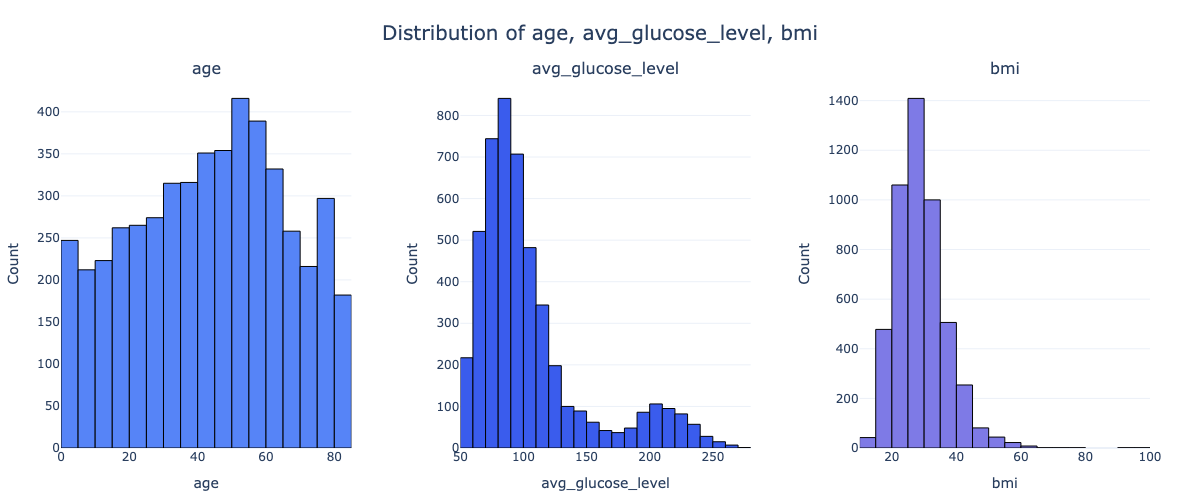

In [12]:
Image(filename="images/numerical_distributions.png")

The histograms reveal the following about `age`, `avg_glucose_level`, and `bmi`:

* **Age:** Shows a relatively uniform distribution across most age ranges, with slight increases in frequency for middle-aged adults (around 45-65). There's a noticeable drop-off for very young (<20) and very old (>80) ages. This uniform distribution is unusual for demographic data and may warrant further investigation into the data collection process or potential sampling biases.

* **Average Glucose Level:** Strongly right-skewed, with a peak around 90-100 mg/dL and a long tail extending to higher values. There's a secondary smaller peak around 200-250 mg/dL, which could indicate a subgroup with diabetes or pre-diabetes.

* **BMI:** Approximately normally distributed, centered around 25-30, with a slight right skew. There are notable outliers at very high BMI values (>60) that warrant further investigation.

Next up, we can move on to the categorical features.

In [34]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
categorical_features_set1 = ['gender', 'hypertension', 'heart_disease','smoking_status']
categorical_features_set2 = ['ever_married', 'work_type', 'residence_type']
categorical_features_set3 = ['smoking_status']

In [35]:
plot_combined_bar_charts(stroke_df, categorical_features_set1, max_features_per_plot=4, save_path="images/categorical_distributions_set1")

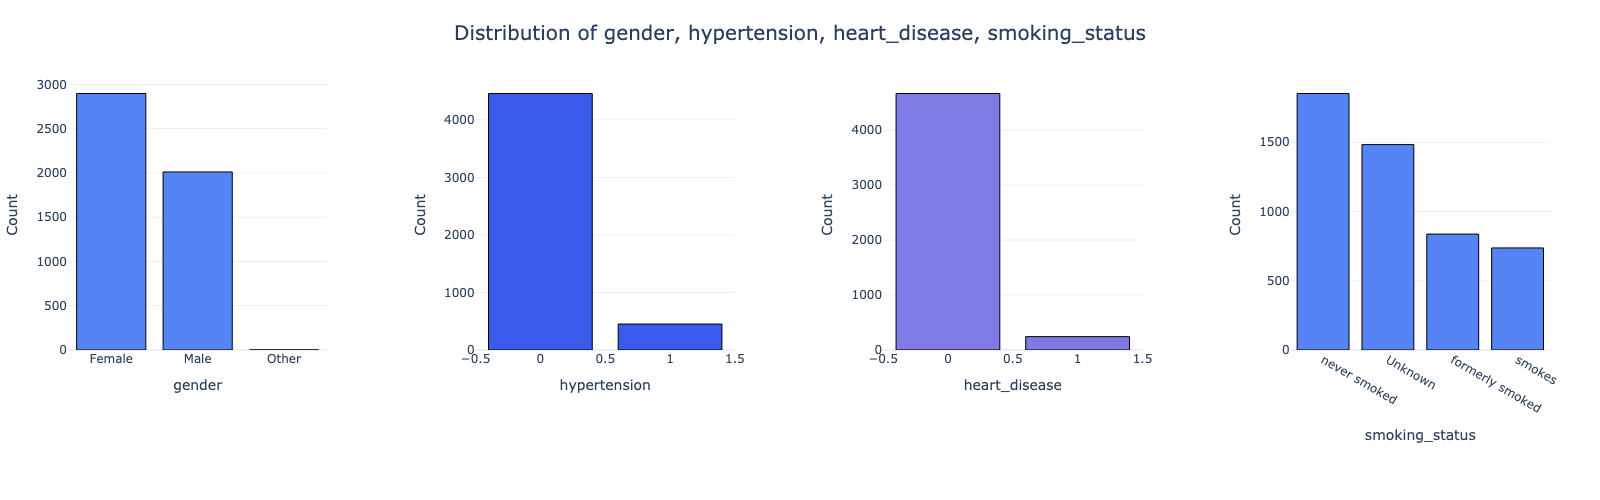

In [36]:
Image(filename="images/categorical_distributions_set1_chunk_1.png")

In [30]:
plot_combined_bar_charts(stroke_df, categorical_features_set2, max_features_per_plot=3, save_path="images/categorical_distributions_set2")

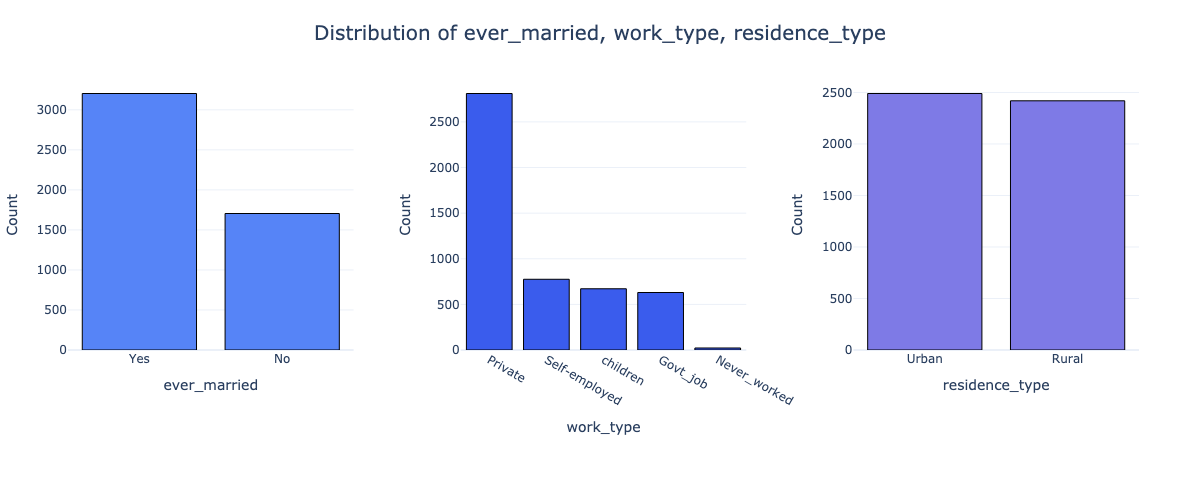

In [31]:
Image(filename="images/categorical_distributions_set2_chunk_1.png")

In [32]:
plot_combined_bar_charts(stroke_df, categorical_features_set3, max_features_per_plot=3, save_path="images/categorical_distributions_set3")

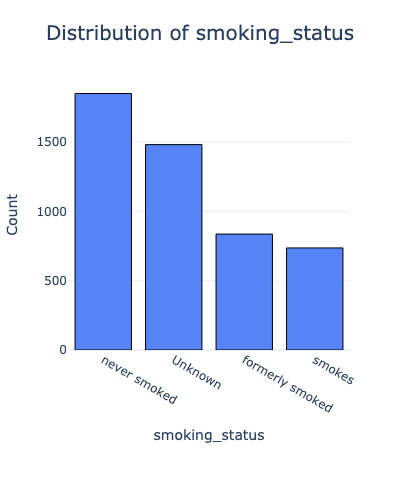

In [33]:
Image(filename="images/categorical_distributions_set3_chunk_1.png")

In [19]:
plot_correlation_matrix(stroke_df, numerical_features + ['stroke'], save_path="images/correlation_matrix.png")

In [20]:
anomalies = detect_anomalies_iqr(stroke_df, numerical_features)
print("Detected anomalies:")
print(anomalies)

No anomalies detected in feature 'age'.
Anomalies detected in feature 'avg_glucose_level':
         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
5     56669    Male  81.0             0              0          Yes   
14     5317  Female  79.0             0              1          Yes   
...     ...     ...   ...           ...            ...          ...   
5061  38009    Male  41.0             0              0          Yes   
5062  11184  Female  82.0             0              0          Yes   
5063  68967    Male  39.0             0              0          Yes   
5064  66684    Male  70.0             0              0          Yes   
5076  39935  Female  34.0             0              0          Yes   

          work_type residence_type  avg_glucose_level   

In [15]:
%run -i stroke_risk_utils.py